# Contexte

En termes de configuration, nous utilisions quelque chose de similaire :

```c
// canal radio
#define RF_CHANNEL                     12

// PANID 802.15.4
#define IEEE802154_CONF_PANID          0x0012

// ou nullrdc_driver
#define NETSTACK_CONF_RDC              contikimac_driver

// présent seulement dans `-full`
#define RF2XX_TX_POWER                 PHY_POWER_m17dBm
#define RF2XX_RX_RSSI_THRESHOLD        RF2XX_PHY_RX_THRESHOLD__m84dBm

// mode opératoire = non storing
#define RPL_CONF_MOP RPL_MOP_NON_STORING

// traffic de type unicast uniquement (pas de multicast) sur RPL
#define RPL_CONF_MOP RPL_MOP_STORING_NO_MULTICAST

// fonction objectif = MRHOF
#define RPL_OF_OCP RPL_OCP_MRHOF

/* RFC6550 defines the default MIN_HOPRANKINC as 256.
 * However, we use MRHOF as a default Objective Function (RFC6719),
 * which recommends setting MIN_HOPRANKINC with care, in particular
 * when used with ETX as a metric. ETX is computed as a fixed point
 * real with a divisor of 128 (RFC6719, RFC6551). We choose to also
 * use 128 for RPL_MIN_HOPRANKINC, resulting in a rank equal to the
 * ETX path cost. Larger values may also be desirable, as discussed
 * in section 6.1 of RFC6719. */
// métrique utilisée = ETX avec diviseur de 128
```

Nous lancions à chaque fois deux variante de chaque type de technologie : une où on ajustait la puissance radio en la diminuant, et une autre où on la laissait par défaut (suffixées `-full` dans la suite de ce rapport).

Nous avons automatisé le lancement des différentse expérimentations ainsi que la récupération des résultats avec l'aide de scripts ZSH.
Nous avons récupéré à chaque fois les logs RPL et IPv6 en activant le DEBUG.
Nous avons également récupéré le résultat des ping et des requêtes COAP (GET et GET avec OBSERVE).

Pour traiter les différentes données, nous avons écrits des scripts shell (par exemple pour générer un CSV avec les résultats des requêtes COAP) ainsi que des scripts Python (pour parser les logs RPL, les paquets IPv6 via un export pcap, et les pings).

Nous avons fait le reste des traitements et la rédaction de ce rapport dans un Notebook Jupyter.
Le dépôt complet (avec un README expliquant comment lancer les expériences et parser les résultats) est disponible à l'adresse: https://github.com/ludovicm67/iot-perf

Note de fin: On a *beaucoup* de données, et beaucoup de scripts pour les parser, mais plus assez de temps pour les mettre correctement en forme.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import re
from datetime import datetime
import networkx as nx
from parse.config import Config
from parse import discover, rpl, pings

In [3]:
# generate all CSV files by running the zsh script
def dateparse (time_in_secs):    
    return datetime.datetime.fromtimestamp(float(time_in_secs))

files = discover.group(discover.discover('./results'))

convergence_data = []
pings_dfs = []
# driver_name = "nullrdc" | "contiki-mac" | "tsch" (or with "-full" suffix)
def plot_driver(driver_name):

    datas = []
    rolling = 30
    graphed = False
        
    configs = files[driver_name]
    for config_path in configs:
        try:
            config = Config.load(config_path)
            start = config.timings.start
            ts = rpl.first_converged(rpl.states(rpl.events(config.nodes)), config.nodes)
            date = datetime.utcfromtimestamp(ts)
            pings_df = pings.parse(config.prefix / 'pings')
            pings_df['driver_name'] = driver_name
            pings_df['experiment_id'] = config.prefix.name
            pings_dfs.append(pings_df)
            convergence_data.append({
                'driver_name': driver_name,
                'experiment_id': config.prefix.name,
                'convergence': ((date - start).seconds)
            })
        except:
            continue
        
        if not graphed:
            fig, axs = plt.subplots(1, 3, figsize=(15, 7))
        for node in config.all_nodes:
            if node.consumption.exists():
                df = node.conso_dataframe()
                
                datas.append({
                    "driver_name": driver_name,
                    "exp_id": config.prefix.name,
                    "node_id": node.uid,
                    "type": node.type.name,
                    "power_avg": df["power"].mean(),
                    "voltage_avg": df["voltage"].mean(),
                    "current_avg": df["current"].mean(),
                })
                
                if graphed:
                    continue
                
                df["power"].rolling(rolling).mean().plot(
                    label="m3-%d #%s (%s)" % (node.num, node.uid, node.type.name),
                    legend=True,
                    ax=axs[0]
                )
                
                df["voltage"].rolling(rolling).mean().plot(
                    label="m3-%d #%s (%s)" % (node.num, node.uid, node.type.name),
                    legend=True,
                    ax=axs[1]
                )
                
                df["current"].rolling(rolling).mean().plot(
                    label="m3-%d #%s (%s)" % (node.num, node.uid, node.type.name),
                    legend=True,
                    ax=axs[2]
                )
                
                axs[0].set_title('Puissance', fontsize=16)
                axs[0].set_ylabel('Puissance (W)')
                axs[0].set_xlabel('Temps (s)')

                axs[1].set_title('Voltage', fontsize=16)
                axs[1].set_ylabel('Voltage (V)')
                axs[1].set_xlabel('Temps (s)')

                axs[2].set_title('Courrant', fontsize=16)
                axs[2].set_ylabel('Courrant (A)')
                axs[2].set_xlabel('Temps (s)')
                
        graphed = True
                
        fig.suptitle('Expérience #%s' % (config.prefix.name), fontsize=20)
        plt.show()
    return datas
        
all_datas = []

# reg = re.compile(r'^coap://\[[0-9a-f:]+::([0-9a-f]+)\]\/.*')
# df = pd.read_csv("coap_stats.csv", index_col="timestamp",date_parser=dateparse, parse_dates=True)
# df["uid"] = df.request_url.replace(reg, r'\1')
# df.head(10)

# Consommation

## NullRDC

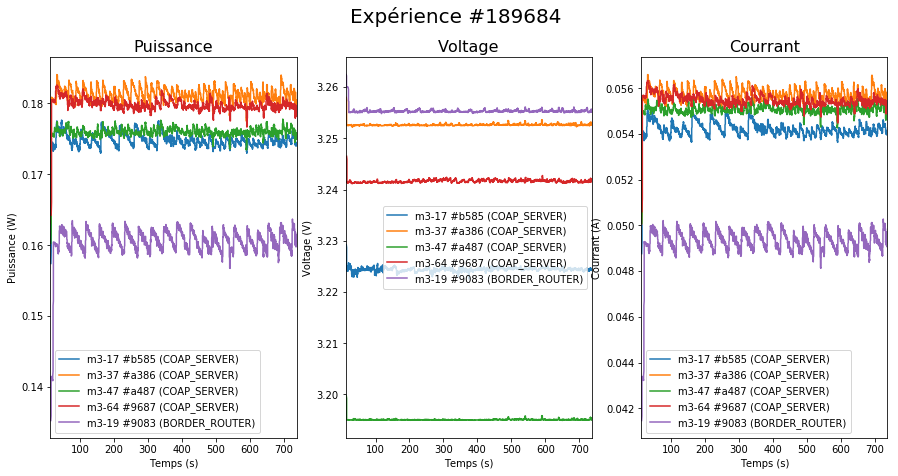

In [4]:
all_datas += plot_driver("nullrdc")

## NullRDC (full)

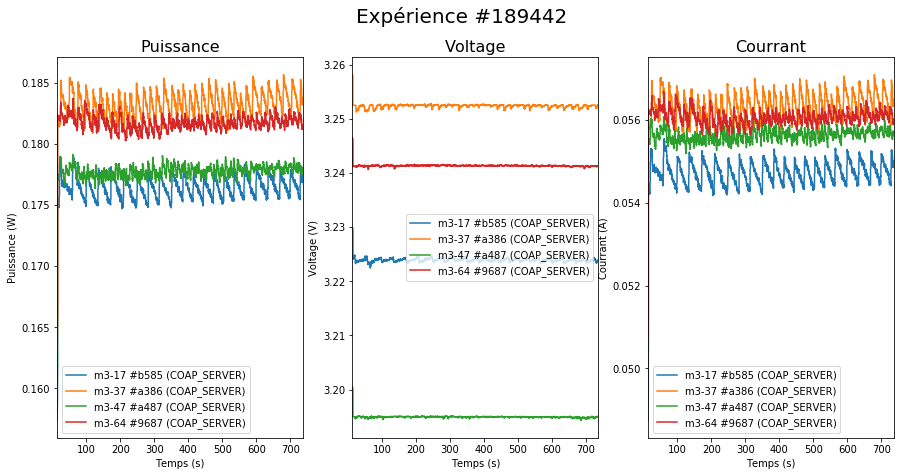

In [5]:
all_datas += plot_driver("nullrdc-full")

## Contiki-mac

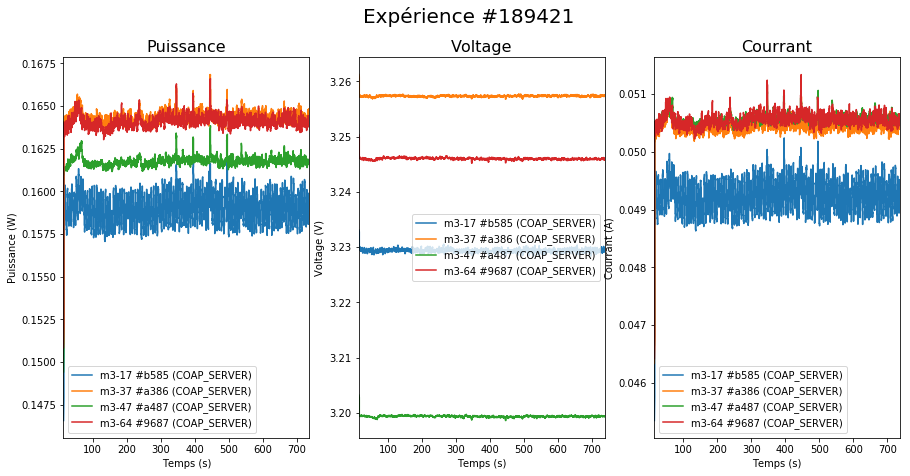

In [6]:
all_datas += plot_driver("contiki-mac")

## Contiki-mac (full)

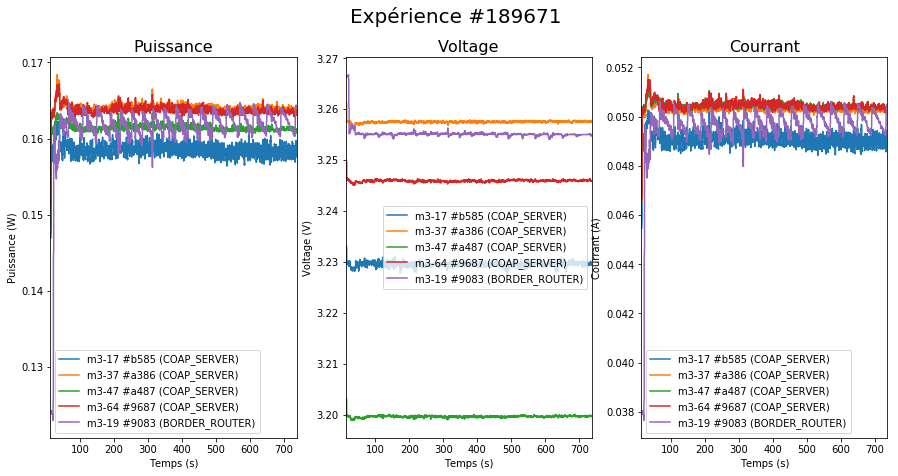

In [7]:
all_datas += plot_driver("contiki-mac-full")

## TSCH

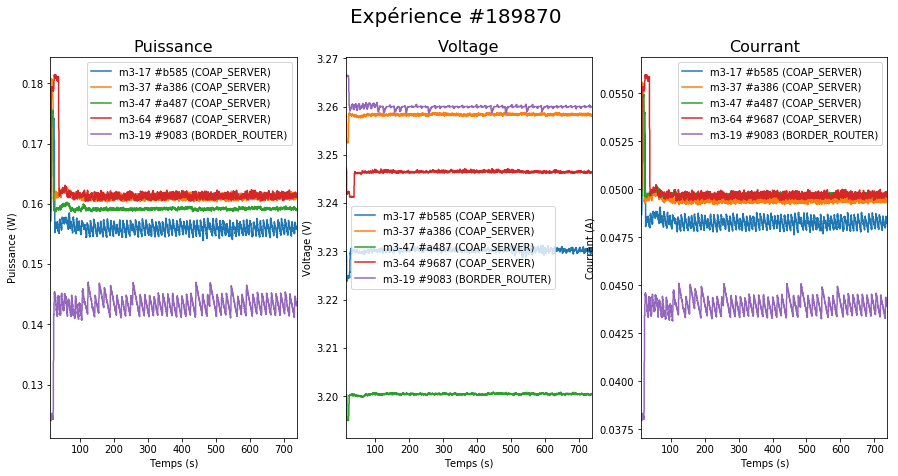

In [8]:
all_datas += plot_driver("tsch")

## TSCH (full)

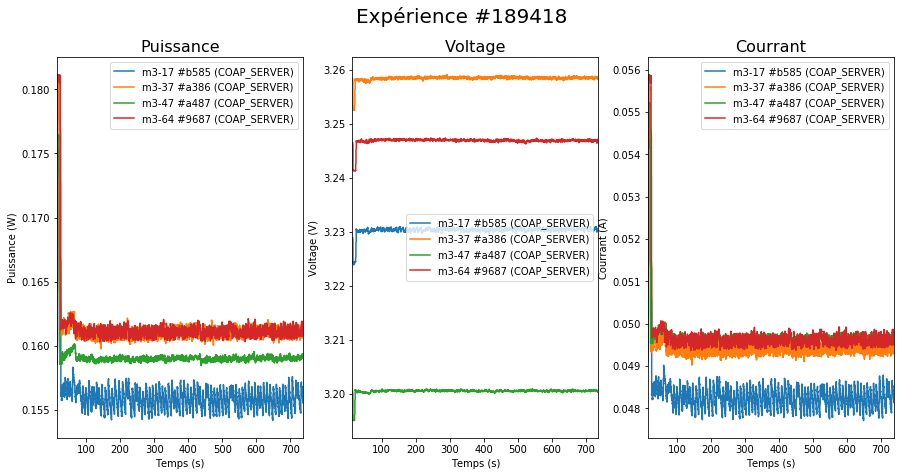

In [9]:
all_datas += plot_driver("tsch-full")

## Comparaison entre les différentes technologies

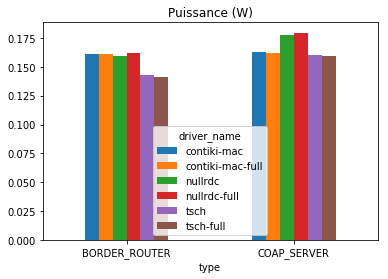

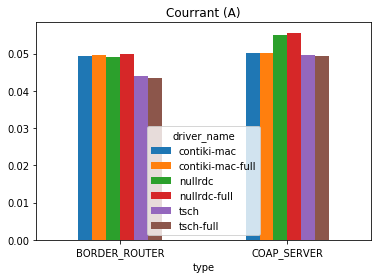

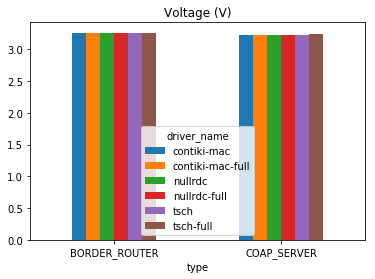

In [10]:
df = pd.DataFrame(all_datas)
df.groupby(['type', 'driver_name']).mean()['power_avg'].unstack().plot.bar(rot=0, title="Puissance (W)")
df.groupby(['type', 'driver_name']).mean()['current_avg'].unstack().plot.bar(rot=0, title="Courrant (A)")
df.groupby(['type', 'driver_name']).mean()['voltage_avg'].unstack().plot.bar(rot=0, title="Voltage (V)")

In [11]:
df.mean()

current_avg    0.051189
exp_id              inf
power_avg      0.165573
voltage_avg    3.234654
dtype: float64

In [12]:
df.groupby(['type']).mean()

,current_avg,power_avg,voltage_avg
type,,,
BORDER_ROUTER,0.047513,0.154754,3.256960
COAP_SERVER,0.051672,0.166997,3.231718


In [13]:
df.groupby(['type', 'driver_name']).mean()

current_avg  power_avg  voltage_avg
type          driver_name                                          
BORDER_ROUTER contiki-mac          0.049497   0.161144     3.255273
              contiki-mac-full     0.049539   0.161280     3.255254
              nullrdc              0.049029   0.159634     3.255613
              nullrdc-full         0.049816   0.162170     3.255064
              tsch                 0.043936   0.143238     3.259988
              tsch-full            0.043420   0.141574     3.260424
COAP_SERVER   contiki-mac          0.050261   0.162497     3.232921
              contiki-mac-full     0.050074   0.161905     3.233153
              nullrdc              0.055058   0.177778     3.228536
              nullrdc-full         0.055602   0.179514     3.228219
              tsch                 0.049568   0.160295     3.233670
              tsch-full            0.049371   0.159670     3.233901

On constate que peut importe la technologie utilisée, et peut importe le type de nœud, le voltage est plutôt similaire (de l'ordre de 3.2V).

La consommations en termes de puissance et de courrant est supérieure pour les border router que les serveurs COAP, notamment pour NullRDC et TSCH, Contiki-mac arrivant à une consommation similaire peu importe le type de nœud.

En termes de consommation (courrant et voltage) au niveau du border router, TSCH est la solution la plus avantageuse. NullRDC et Contiki-mac ont des valeurs similaires.

En termes de consommation (courrant et voltage) au niveau des serveurs COAP, Contii-mac et TSCH offrent des performances similaires et sont donc les solutions les plus avantageuses. NullRDC est plus consommatrice que les deux autres solutions.

# Temps de convergence par driver

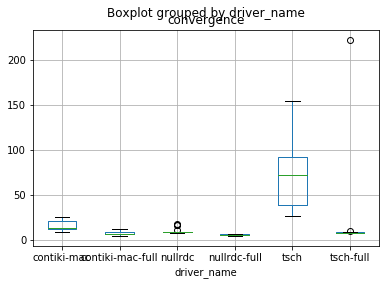

In [17]:
df = pd.DataFrame(convergence_data)
df.boxplot(column='convergence', by='driver_name')

# Topologies successives d'une expérince avec TSCH

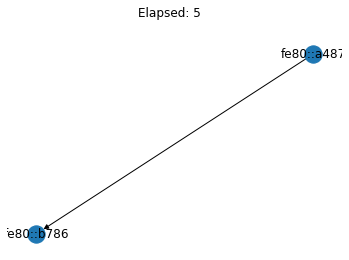

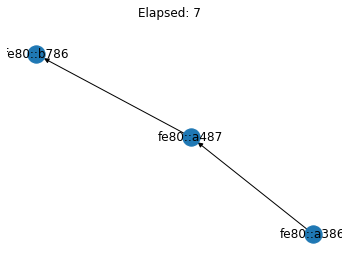

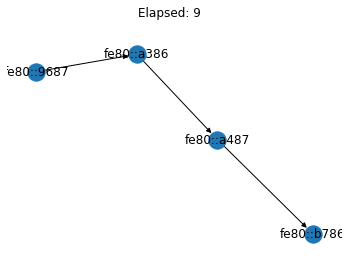

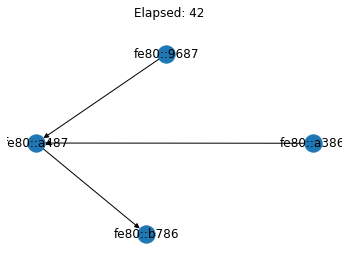

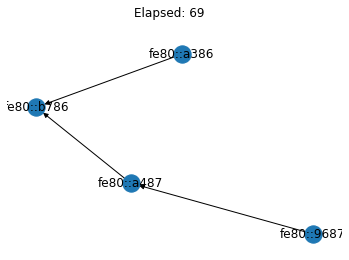

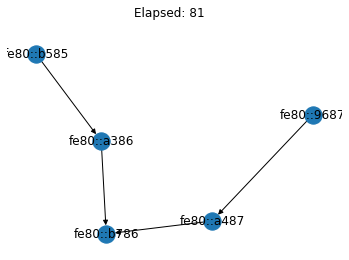

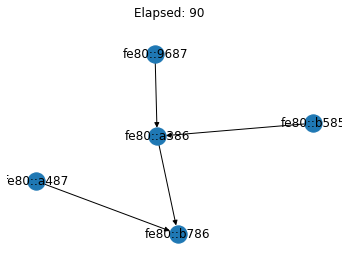

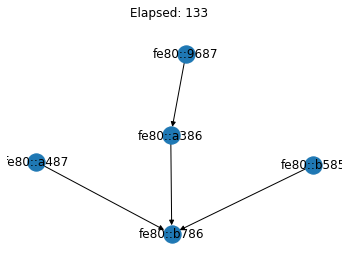

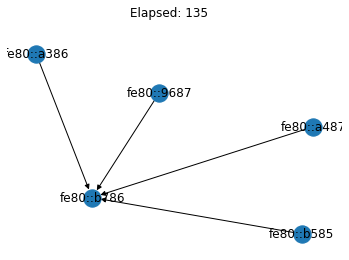

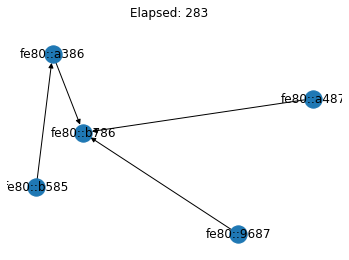

In [18]:
c = Config.load('results/189342')
start = c.timings.start
for ts, state in rpl.states(rpl.events(c.nodes)):
    date = datetime.utcfromtimestamp(ts)
    fig, ax = plt.subplots()
    fig.suptitle('Elapsed: %d' % ((date - start).seconds))
    graph = rpl.to_graph(state)
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, ax=ax)


# Latence des pings par driver

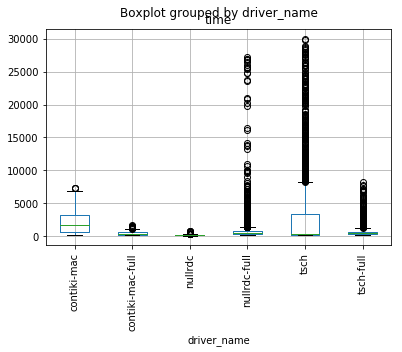

In [21]:
ds = pd.concat(pings_dfs)
ds[ds['time'] < 30000].boxplot('time', by='driver_name', rot=90)